<a href="https://colab.research.google.com/github/salehi-sepideh/TimeSeries-SARIMAX/blob/main/TimeSeries_Forecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

In [9]:
data=pd.read_csv('h2o_exog.csv')
data.head()

,fecha,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199


In [10]:
data=data.rename(columns={'fecha':'date'})
data['date']=pd.to_datetime(data['date'] , format='%Y-%m-%d')
data=data.set_index('date')
data=data.asfreq('MS')
data=data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 195 entries, 1992-04-01 to 2008-06-01
Freq: MS
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       195 non-null    float64
 1   exog_1  195 non-null    float64
 2   exog_2  195 non-null    float64
dtypes: float64(3)
memory usage: 6.1 KB


In [16]:
data.isnull().any(axis=1).sum()

0

In [17]:
steps=36
data_train=data[:-steps]
data_test=data[-steps:]

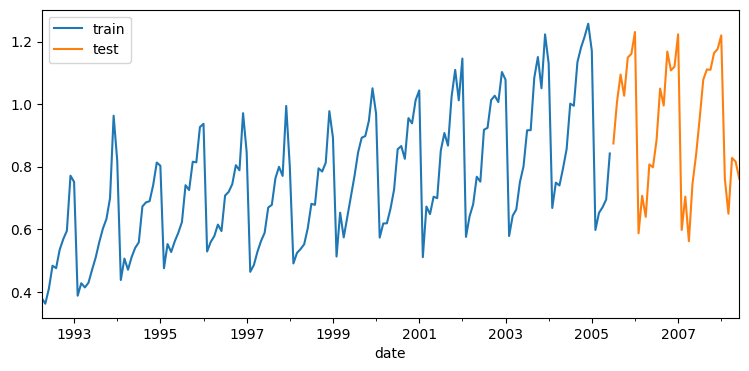

In [19]:
fig,ax=plt.subplots(figsize=(9,4))
data_train['y'].plot(ax=ax , label='train')
data_test['y'].plot(ax=ax , label='test')
ax.legend()

In [20]:
forecaster=ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123),
                             lags=6)
forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-11-01 14:41:24 
Last fit date: 2024-11-01 14:41:25 
Skforecast version: 0.13.0 
Python version: 3.10.12 
Fo

In [24]:
steps=36
predictions=forecaster.predict(steps=steps)
predictions.head()

,pred
2005-07-01,0.878756
2005-08-01,0.882167
2005-09-01,0.973184
2005-10-01,0.983678
2005-11-01,0.849494


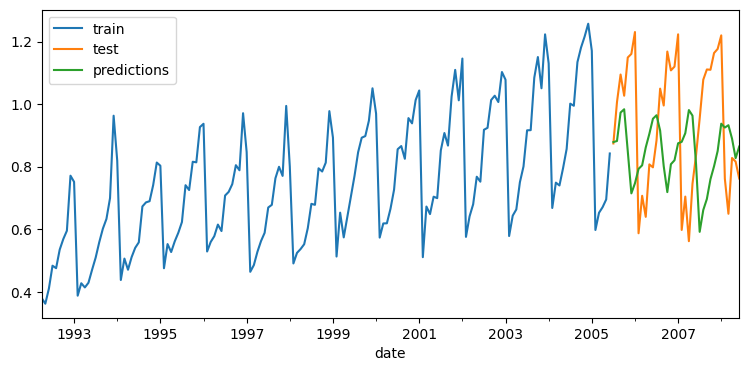

In [25]:
fig,ax=plt.subplots(figsize=(9,4))
data_train['y'].plot(ax=ax , label='train')
data_test['y'].plot(ax=ax , label='test')
predictions.plot(ax=ax , label='predictions')
ax.legend()

In [28]:
error_mse=mean_squared_error(data_test['y'] , predictions)
print(f'test error(mse):{error_mse}')

test error(mse):0.07326833976120374


The prediction wasn't accurate, and it didn't achieve good precision.
Next step: Hyper-tuning the algorithm.

In [31]:
steps=36
forecaster=ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=12)
lags_grid=[10,20]
param_grid={'n_estimators':[100,500] , 'max_depth':[3,5,10]}
result_grid=grid_search_forecaster(
                       forecaster  = forecaster,
                        y           = data_train['y'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.9),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
               )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.007414172088730407



In [32]:
regressor=RandomForestRegressor(max_depth=10 , n_estimators=100 , random_state=123)
forecaster=ForecasterAutoreg(regressor=regressor , lags=20)
forecaster.fit(y=data_train['y'])
predictions=forecaster.predict(steps=steps)

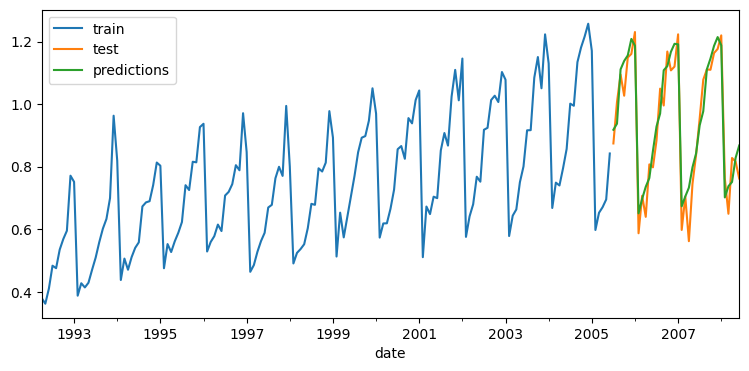

In [33]:
fig,ax=plt.subplots(figsize=(9,4))
data_train['y'].plot(ax=ax , label='train')
data_test['y'].plot(ax=ax , label='test')
predictions.plot(ax=ax , label='predictions')
ax.legend()

In [34]:
error_mse=mean_squared_error(data_test['y'] , predictions)
print(f'error_mse:{error_mse}')

error_mse:0.0043337019401125
